In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd



In [20]:


# Load the data
data = pd.read_csv('../data/raw/missiles-acled-18-october-2023.csv', delimiter=';')


In [21]:
# **Step 1: Clean and Filter Data**
missile_data = data[(data['sub_event_type'].isin(['Shelling/artillery/missile attack', 'Air/drone strike'])) & 
                    (data['actor1'] == 'Military Forces of Israel (2022-)')]


In [22]:
# **Step 2: Handle Missing Values**
missile_data['latitude'] = missile_data['latitude'].fillna(missile_data['latitude'].mean())
missile_data['longitude'] = missile_data['longitude'].fillna(missile_data['longitude'].mean())
missile_data['fatalities'] = missile_data['fatalities'].fillna(0)


C:\Users\matc_\AppData\Local\Temp\ipykernel_18996\4225160965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missile_data['latitude'] = missile_data['latitude'].fillna(missile_data['latitude'].mean())
C:\Users\matc_\AppData\Local\Temp\ipykernel_18996\4225160965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missile_data['longitude'] = missile_data['longitude'].fillna(missile_data['longitude'].mean())
C:\Users\matc_\AppData\Local\Temp\ipykernel_18996\4225160965.py:4: SettingWithCopyWarning: 
A value

In [23]:
# **Step 3: Aggregate Data by Location**
agg_data = missile_data.groupby('location').agg({
    'event_id_cnty': 'count',  # Count of missile events per location
    'fatalities': 'sum',       # Sum of fatalities per location
    'latitude': 'mean',        # Average latitude
    'longitude': 'mean',       # Average longitude
}).reset_index()
agg_data.rename(columns={'event_id_cnty': 'missile_attack_count', 'fatalities': 'total_fatalities'}, inplace=True)


In [24]:
# **Step 4: Create a PTSD Likelihood Proxy**
agg_data['ptsd_likelihood'] = agg_data.apply(
    lambda row: 1 if row['missile_attack_count'] > 3 and row['total_fatalities'] > 1 else 0, axis=1
)


In [25]:
# **Step 5: Feature Engineering**
features = ['missile_attack_count', 'total_fatalities']
# Add interaction and log transformation features
agg_data['attack_fatality_interaction'] = agg_data['missile_attack_count'] * agg_data['total_fatalities']
agg_data['log_missile_attack_count'] = np.log1p(agg_data['missile_attack_count'])
agg_data['log_total_fatalities'] = np.log1p(agg_data['total_fatalities'])
features.extend(['attack_fatality_interaction', 'log_missile_attack_count', 'log_total_fatalities'])
# Prepare feature matrix (X) and target vector (y)
X = agg_data[features]
y = agg_data['ptsd_likelihood']


In [26]:
# **Step 6: Normalize/Scale Features**
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [27]:
# **Step 7: Train-Test Split**
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [28]:
# **Step 8: Balance Dataset using SMOTE (if necessary)**
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [29]:
# **Train Logistic Regression Model**
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train_smote, y_train_smote)
y_pred = logreg.predict(X_test)
print('Logistic Regression Results:')
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Logistic Regression Results:
Accuracy: 0.9074074074074074
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91        86
           1       0.84      0.99      0.91        76

    accuracy                           0.91       162
   macro avg       0.91      0.91      0.91       162
weighted avg       0.92      0.91      0.91       162

Confusion Matrix:
 [[72 14]
 [ 1 75]]


In [30]:
# **Train Random Forest Model**
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
print('Random Forest Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Classification Report:\n', classification_report(y_test, y_pred_rf))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        76

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162

Confusion Matrix:
 [[86  0]
 [ 0 76]]


In [31]:
# **Train Support Vector Machine (SVM) Model**
svm = SVC(random_state=42)
svm.fit(X_train_smote, y_train_smote)
y_pred_svm = svm.predict(X_test)
print('SVM Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('Classification Report:\n', classification_report(y_test, y_pred_svm))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))


SVM Results:
Accuracy: 0.9629629629629629
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.96        86
           1       0.94      0.99      0.96        76

    accuracy                           0.96       162
   macro avg       0.96      0.96      0.96       162
weighted avg       0.96      0.96      0.96       162

Confusion Matrix:
 [[81  5]
 [ 1 75]]


In [32]:
# **Hyperparameter Tuning with GridSearchCV (for RandomForest)**
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train_smote, y_train_smote)
print('Best Parameters:', grid_search.best_params_)
y_pred_grid = grid_search.best_estimator_.predict(X_test)
print('GridSearchCV Random Forest Results:')
print('Accuracy:', accuracy_score(y_test, y_pred_grid))
print('Classification Report:\n', classification_report(y_test, y_pred_grid))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_grid))


Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
GridSearchCV Random Forest Results:
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00        76

    accuracy                           1.00       162
   macro avg       1.00      1.00      1.00       162
weighted avg       1.00      1.00      1.00       162

Confusion Matrix:
 [[86  0]
 [ 0 76]]


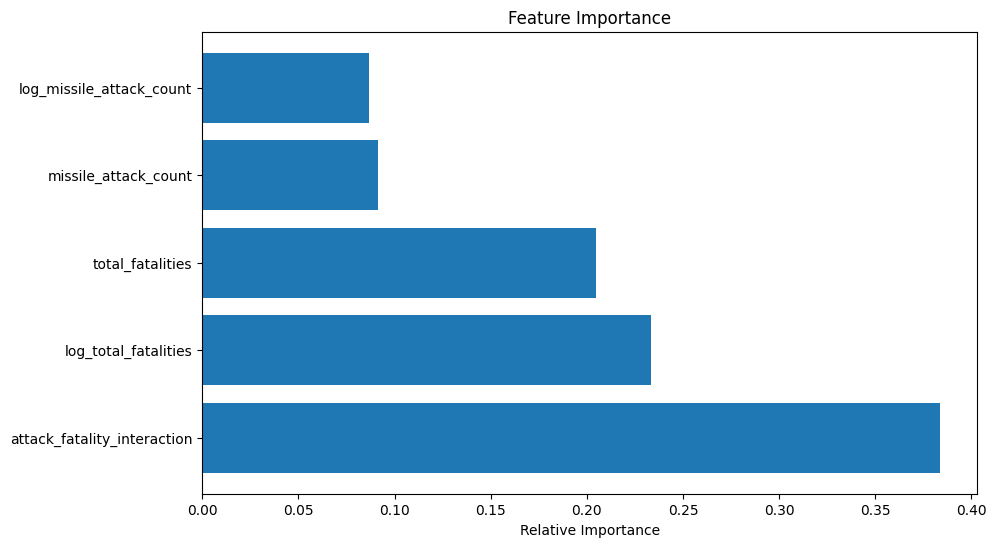

In [33]:
# **Feature Importance Visualization for RandomForest**
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), np.array(features)[indices])
plt.xlabel('Relative Importance')
plt.show()


In [34]:
# **Cross-Validation with Random Forest**
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy')
print('Cross-validation results:')
print('Mean Accuracy:', np.mean(cv_scores))
print('Standard Deviation:', np.std(cv_scores))


Cross-validation results:
Mean Accuracy: 1.0
Standard Deviation: 0.0


In [35]:
import folium
from folium.plugins import MarkerCluster

# Initialize a map centered around Lebanon's geographic center
m = folium.Map(location=[33.8547, 35.8623], zoom_start=8)  # Coordinates for Lebanon's center

# Add a marker cluster for better visualization
marker_cluster = MarkerCluster().add_to(m)

# Iterate over the aggregated data to add markers
for index, row in agg_data.iterrows():
    color = 'green' if row['ptsd_likelihood'] == 1 else 'red'
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"Location: {row['location']}<br>Missile Attacks: {row['missile_attack_count']}<br>Fatalities: {row['total_fatalities']}<br>PTSD Likelihood: {'High' if row['ptsd_likelihood'] == 1 else 'Low'}"
    ).add_to(marker_cluster)

# Save the map as an HTML file to visualize
m.save('lebanon_ptsd_map.html')
